# INTRO

This notebook is following 
https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda

Goal is to predict the _next hour_ electricity price. 
- EDA
- Feature engineering 

Modelling is done via several achitectures


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

2023-10-01 11:22:34.302391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))


# Datasets
Here we have two .csv files 
- weather...csv _Hourly_ weather conditions
- energy...csv _Hourly_ energy generation, load, and price (energy generation is in MWh)

Weather data is for __5 Big cities__ that cover all the spain territory. 

In [3]:
df_weather = pd.read_csv("./weather_features.csv", parse_dates=["dt_iso"])
df_energy = pd.read_csv("./energy_dataset.csv", parse_dates=["time"])

### EDA on energy dataset

- Examine zeroes and nans 
- Remove columns that are fully 0 or nan
- Find where Nans are with visualization
- Use interpolation to fill nans if there is not much missing (do not drop rows)

In [4]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
# check which mumber columns are all NaNs
for key, vals in df_energy.select_dtypes(include=np.number).items():
    if (len(vals[~np.isnan(np.array(vals))]) == 0):
        print(f"All nans for {key}")
# check which mumber columns are mostly 0
for key, vals in df_energy.select_dtypes(include=np.number).items():
    if (len(np.array(vals)[np.array(vals)==0.]) > 0.9 * len(np.array(vals))):
        print(f"All zeroes for {key}")
# drop these columns from the dataset
df_energy = df_energy.drop(
    [
        'generation fossil coal-derived gas','generation fossil oil shale', 
        'generation fossil peat', 'generation geothermal', 
        'generation hydro pumped storage aggregated', 'generation marine', 
        'generation wind offshore', 'forecast wind offshore eday ahead',
        'total load forecast', 'forecast solar day ahead',
        'forecast wind onshore day ahead'
    ], axis=1
)
df_energy.describe().round(2)

All nans for generation hydro pumped storage aggregated
All nans for forecast wind offshore eday ahead
All zeroes for generation fossil coal-derived gas
All zeroes for generation fossil oil shale
All zeroes for generation fossil peat
All zeroes for generation geothermal
All zeroes for generation marine
All zeroes for generation wind offshore


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [6]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [7]:
# convert time to datetime object and set index
df_energy["time"] = pd.to_datetime(df_energy["time"],utc=True,infer_datetime_format=True)
df_energy = df_energy.set_index("time")

In [8]:
# Find nans and duplicates in the set 
print("Total missing/NaN is: {}".format(
    df_energy.isnull().values.sum()
))
print("Total duplicates in data: {}".format(
    df_energy.duplicated(keep="first").sum()
))

Total missing/NaN is: 292
Total duplicates in data: 0


No duplicates.  
Nans -> fill with interpolation (important for time-seris)

In [9]:
# Find the number of Nans in each column 
df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Important that there are no nans in the target variable `price actual`.  
Visualize the column with the largest amount of nans

In [56]:
# Define a function to plot different types of time series
def plot_series(
        df : pd.DataFrame = None, column : str = None, series = pd.Series([]), 
        label=None, ylabel=None, title=None, start=0, end=None
):
    sns.set()
    fig,ax = plt.subplots(figsize=(15,5))
    ax.set_xlabel("time",fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel,fontsize=16)
    if series.any():
        ax.plot(series,label=label)
        ax.set_ylabel(ylabel,fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title,fontsize=24)
    ax.grid(True)
    return ax

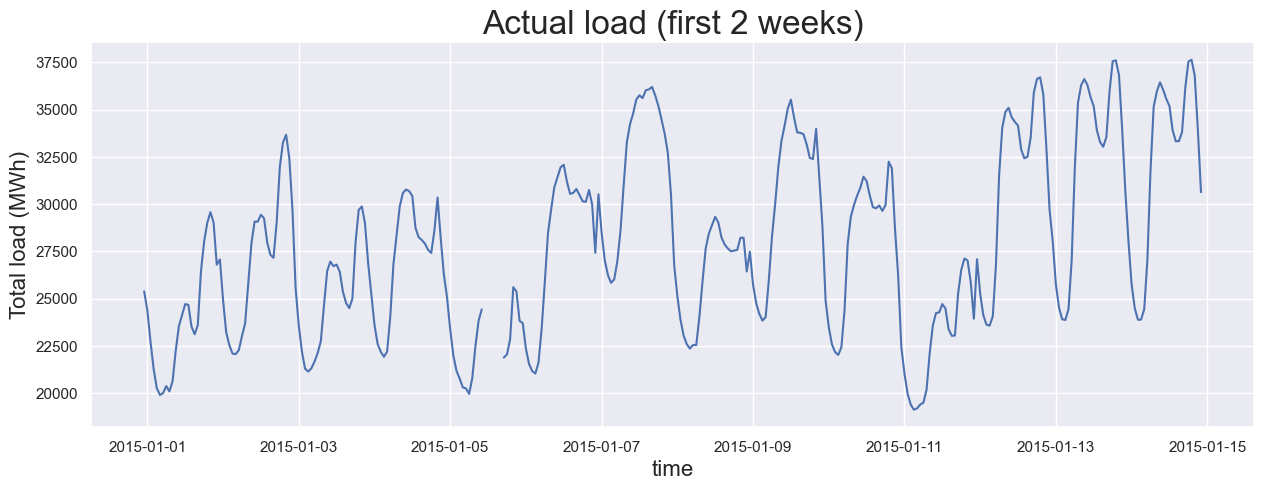

In [57]:
# Plot the actual load
ax = plot_series(df=df_energy,column="total load actual", ylabel="Total load (MWh)",
                 title="Actual load (first 2 weeks)", start=0, end=24*7*2)
plt.show()

Note _missing data_ that would have to be filled with _interpolation_  
Consider if null values are present for other columns as well  

In [12]:
# Display the rows with null values
df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.01,69.79


Following examination will confirm that nans exist in all columns for the same time window.  
Employ linear interpolation for missing values

In [13]:
# Display the number of non-zero values in each column
print("non-zero values in each column\n", 
      df_energy.astype(bool).sum(axis=0),sep="\n")

non-zero values in each column

generation biomass                             35060
generation fossil brown coal/lignite           24547
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22457
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


Large number of zeros in `generation hydro pumped storage consumption` is because this energy generation is used only at peap production

> Dataset is cleaned

# Weather features dataset

In [14]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [15]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


Same number of rows in each column. 
- Check if this holds true for each city. 

Note:
- Temperature is in kelvin
- Pressure has outliers (it can be so large)
- Wind has outliers
- "rain_1h" must be < "rain_3h" however, this is not the case. 

In [16]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [17]:
# Convert columns with int64 type values to float64 type
def df_convert_dtypes(df : pd.DataFrame, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df
df_weather = df_convert_dtypes(df_weather,np.int64, np.float64)

In [18]:
# Display average weather features grouped by each city
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [19]:
# Display average weather features grouped by each city
mean_weather_by_city = df_weather.groupby("city_name").mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [20]:
# Find nans and duplicates in weather

nans = df_weather.isnull().values.sum()
print(f"Nans={nans}")

dups = df_weather.duplicated(keep="first").sum()
print(f"dups={dups}")

cities = df_weather["city_name"].unique()
grouped_weather = df_weather.groupby("city_name")

for city in cities:
    datas = grouped_weather.get_group(city).shape[0]
    print(f"City={city} has {datas} data")

Nans=0
dups=8622
City=Valencia has 35145 data
City=Madrid has 36267 data
City=Bilbao has 35951 data
City= Barcelona has 35476 data
City=Seville has 35557 data


Data is not the same for each city.   
Duplicates present.  

Needs cleaning.  

In [21]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(
    subset=["time","city_name"], keep="last"
).set_index("time")

df_weather = df_weather.reset_index().drop_duplicates(
    subset=["time","city_name"], keep="first"
).set_index("time")

In [24]:
# Display the number of rows in each dataframe again
print(f"df_energy rows = {df_energy.shape[0]}")
grouped_weather = df_weather.groupby("city_name")
for city in cities:
    n = grouped_weather.get_group(city).shape[0]
    print(f"For city {city} there are {n} rows")
print(df_weather.head())

df_energy rows = 35064
For city Valencia there are 35064 rows
For city Madrid there are 35064 rows
For city Bilbao there are 35064 rows
For city  Barcelona there are 35064 rows
For city Seville there are 35064 rows
                          city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2

There is some redundant information in df_weather.  
We need to remove it, but check for consistency first.  

In [26]:
# Display all the unique values in the column 'weather_description'
weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [27]:
weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [28]:
weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

Most information (unique values) is in columns `descritption` and `id`. So we need to pick one of those.  

Check for consistency of the information in each column because there are _duplicate rows_ and we chose one of them.  

Compare the two options with R2 statistic. 

In [29]:
def encode_and_display_r2_score(df_1,df_2, column, categorical=False):
    dfs = [df_1,df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print(f"R2 of {column} is {r2.round(3)}")

In [31]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R2 of weather_description is 0.973
R2 of weather_main is 0.963
R2 of weather_id is 0.921


Result shows inconsistencies in data.  
Qualitative columns contain duplicate information of the weather.  
We need only one.  
$R^2$ shows that it is best to use one-hot encoded `description` or `main`. (The similarity in R2 is due to encoding. Proper encoding requires _Levenshtein distance_). 

In [32]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

In [33]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R2 of temp is 1.0
R2 of temp_min is 1.0
R2 of temp_max is 1.0
R2 of pressure is 1.0
R2 of humidity is 1.0
R2 of wind_speed is 1.0
R2 of wind_deg is 1.0
R2 of rain_1h is 1.0
R2 of rain_3h is 1.0
R2 of snow_3h is 1.0
R2 of clouds_all is 1.0


In [34]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


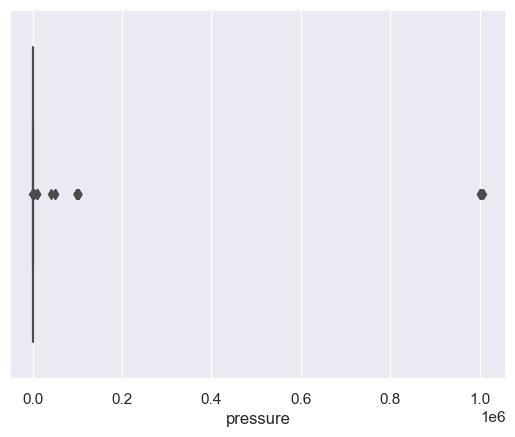

In [36]:
# check for outliers
sns.boxplot(x=df_weather["pressure"])
plt.show()

Now, there are __no__ duplicates and the number of rows for each city is the same as number of rows in _dfenergy_.  

Last step:  
Fixing outliers

Extreme pressures are obviously a mistake.  
We set as nan all values that $>1051$ hPa, which is the highest recorded pressure;  
Same for lower bound. 

In [38]:
df_weather.loc[df_weather.pressure > 1051, "pressure"] = np.nan
df_weather.loc[df_weather.pressure < 931, "pressure"] = np.nan

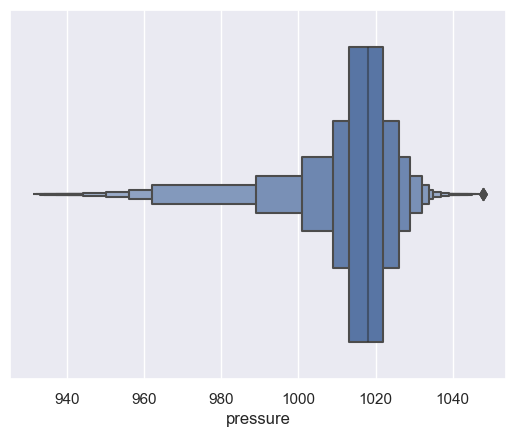

In [40]:
sns.boxenplot(x=df_weather.pressure)
plt.show()

In [46]:
# replace outliers in wind speed
df_weather.loc[df_weather.wind_speed > 50, "wind_speed"] = np.nan

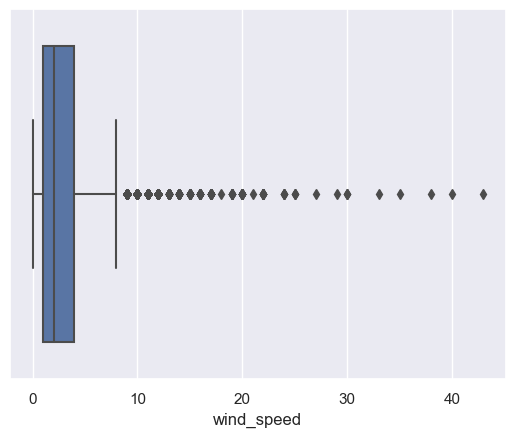

In [47]:
sns.boxplot(x=df_weather.wind_speed)
plt.show()

In [48]:
# Fill nans with interpolation now
df_weather.interpolate(method="linear",
                       limit_direction="forward",
                       inplace=True,
                       axis=0)

# Merging datasets

In [49]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [50]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'wind_spead_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'rain_3h_Bilbao'

In [52]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_final based on all columns.'
      .format(temp_final))

There are 175612 missing values or NaNs in df_final.

There are 0 duplicate rows in df_final based on all columns.


# Visualization

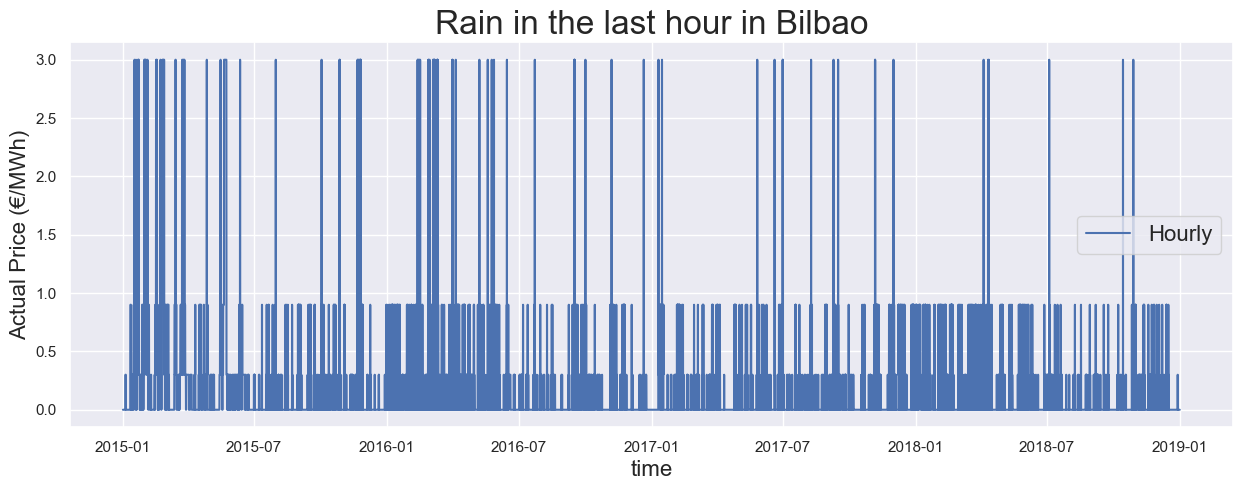

In [58]:
ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

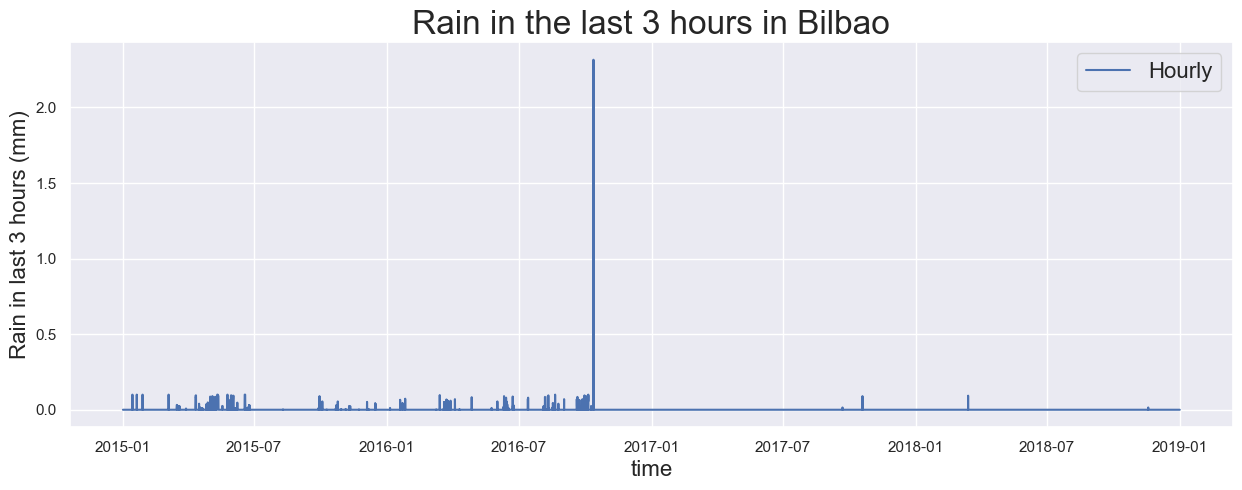

In [59]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

#### Observation:  
`rain_3h` is an unreliable feature that is to be dropped

In [61]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

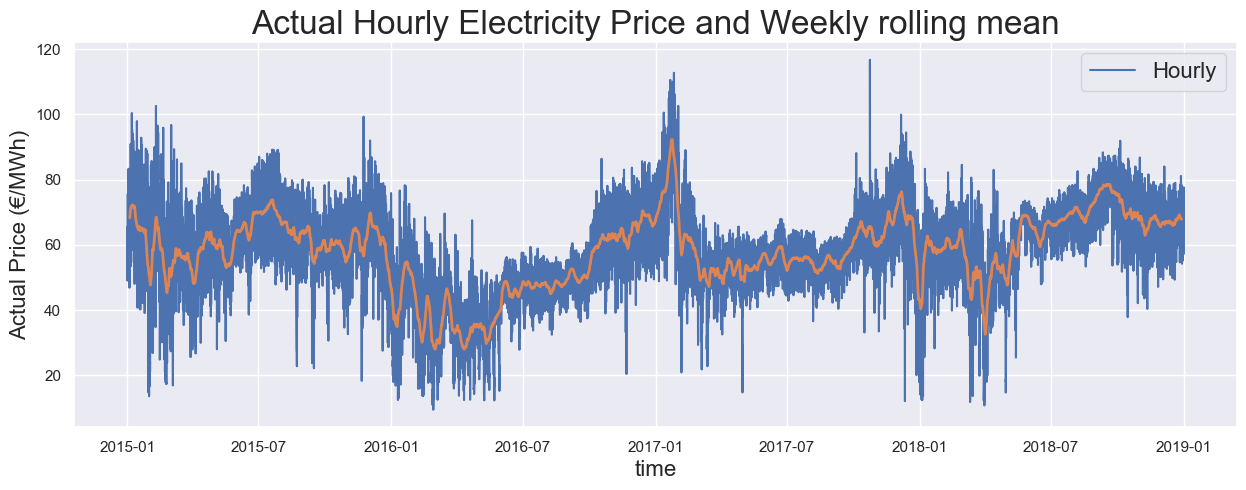

In [62]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

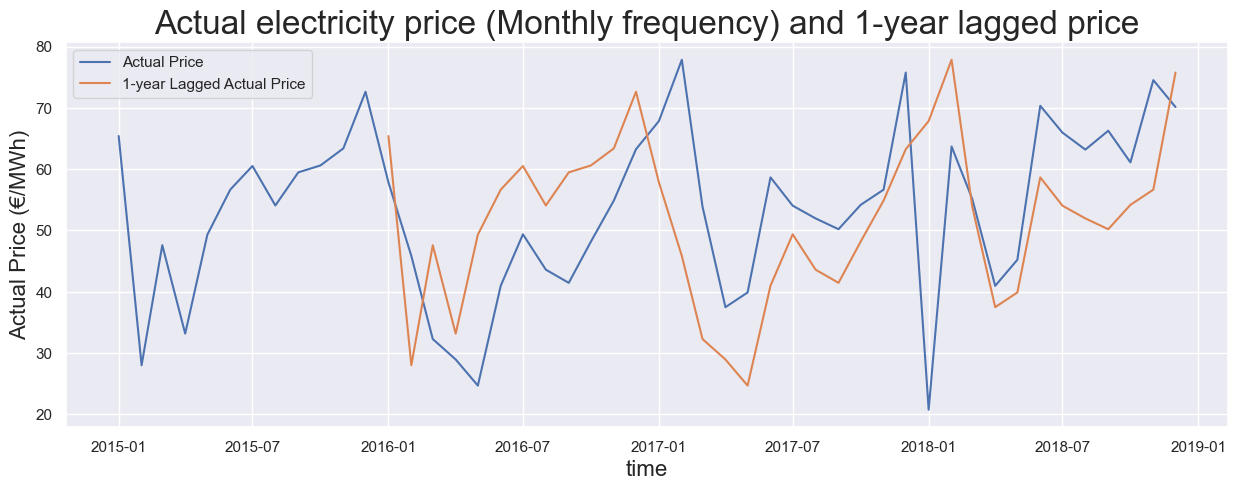

In [63]:
# Plot electricity price (monthly frequence) and 1 year lagged series
monthly_price = df_final["price actual"].asfreq("M")
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final["price actual"].asfreq("M").shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()


Plot shows seasonal patterns in data at _a monthly scale_, as spikes occure at near the same month.  
- New feature for a month is needed

Lets consider another weekly 

In [ ]:
ax = plot_series(df_final, "price actual", label="Hourly", 
                 ylabel="Actual Price", 
                 start = 1 + 24 * 500, end+1 + 24*515)